# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [2]:
boston = pd.read_csv('../data/boston_data.csv')

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [3]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [4]:
boston.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.194770,0.404249,-0.060688,0.405290,-0.172226,0.349288,-0.376493,0.603044,0.565047,0.292092,-0.377436,0.428940,-0.400956
zn,-0.194770,1.000000,-0.532268,-0.037290,-0.497114,0.302404,-0.546587,0.659018,-0.311313,-0.289332,-0.371315,0.176350,-0.412075,0.355608
indus,0.404249,-0.532268,1.000000,0.059928,0.760913,-0.353589,0.630048,-0.702583,0.616375,0.722828,0.356549,-0.378189,0.608309,-0.501698
chas,-0.060688,-0.037290,0.059928,1.000000,0.100650,0.090146,0.084852,-0.103124,-0.022561,-0.043708,-0.121835,0.042580,-0.041061,0.141400
nox,0.405290,-0.497114,0.760913,0.100650,1.000000,-0.266114,0.728882,-0.762469,0.612115,0.660607,0.166715,-0.393876,0.587573,-0.439225
rm,-0.172226,0.302404,-0.353589,0.090146,-0.266114,1.000000,-0.210589,0.178700,-0.173222,-0.241733,-0.323330,0.128410,-0.578025,0.683541
age,0.349288,-0.546587,0.630048,0.084852,0.728882,-0.210589,1.000000,-0.734915,0.467341,0.503830,0.231820,-0.276469,0.602001,-0.390863
dis,-0.376493,0.659018,-0.702583,-0.103124,-0.762469,0.178700,-0.734915,1.000000,-0.503471,-0.526938,-0.206016,0.306445,-0.500912,0.264876
rad,0.603044,-0.311313,0.616375,-0.022561,0.612115,-0.173222,0.467341,-0.503471,1.000000,0.917344,0.487733,-0.468700,0.499279,-0.423508
tax,0.565047,-0.289332,0.722828,-0.043708,0.660607,-0.241733,0.503830,-0.526938,0.917344,1.000000,0.465997,-0.462250,0.542732,-0.495792


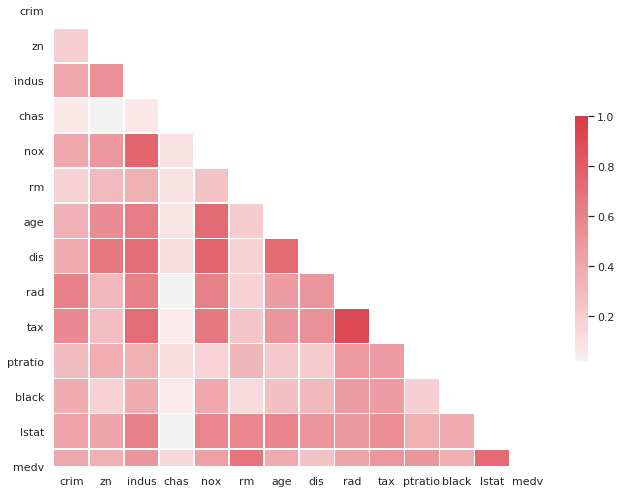

In [5]:
sns.set(style="white")

# Compute the correlation matrix
corr = abs(boston.corr())

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
## i'd love to know what these variables mean

In [7]:
boston.crim.max()

88.9762

In [8]:
boston.crim.min()

## some measurement of absolute crimes?

0.00632

In [9]:
boston.black.describe()
## what the hell is this? Louisiana?

count    404.000000
mean     355.068243
std       94.489572
min        0.320000
25%      374.710000
50%      391.065000
75%      396.007500
max      396.900000
Name: black, dtype: float64

In [10]:
from sklearn.datasets import load_boston

In [11]:
boston_sk = load_boston()

In [12]:
print(boston_sk.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

In [13]:
## Now i understand what the vars mean


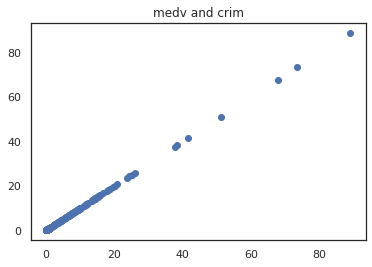

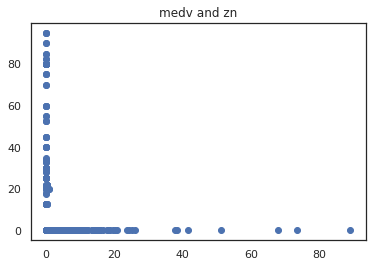

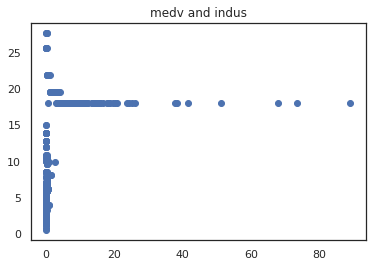

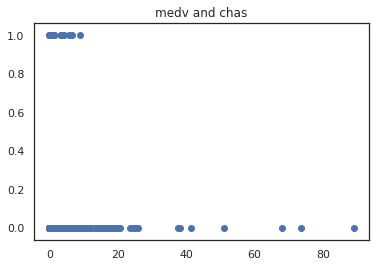

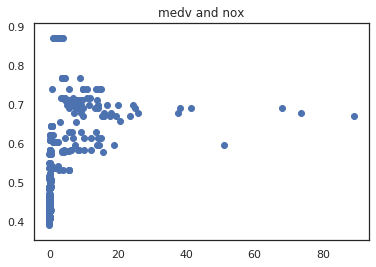

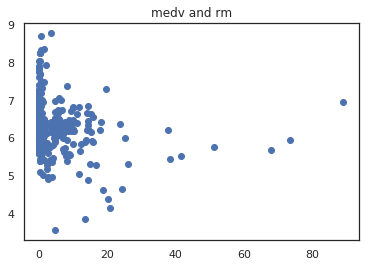

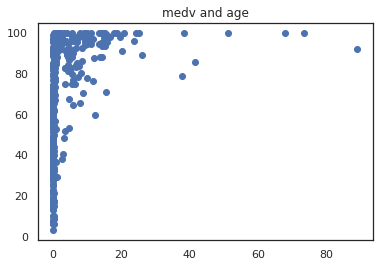

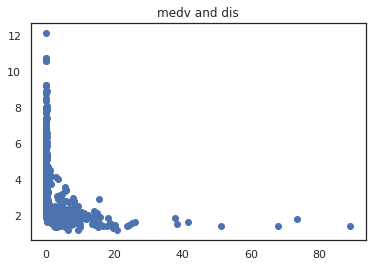

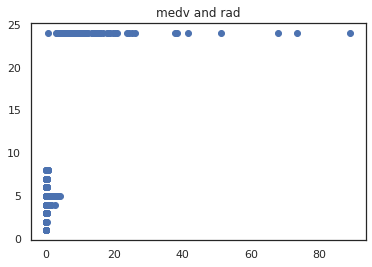

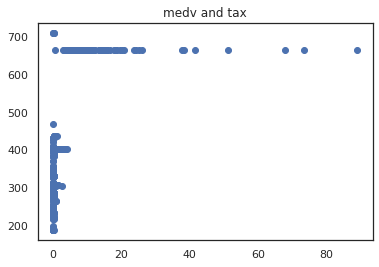

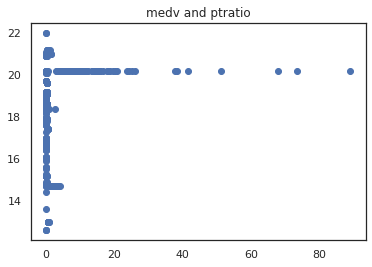

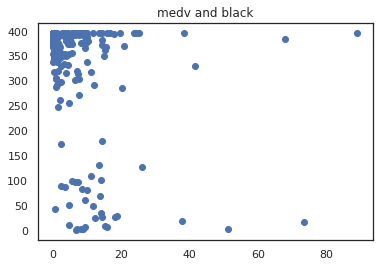

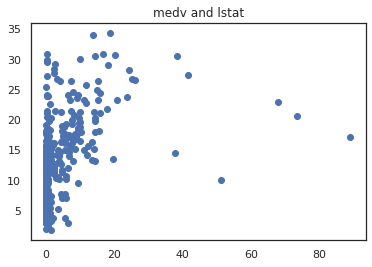

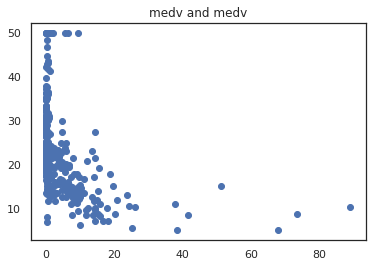

In [14]:
for x in boston.columns:
    plt.figure()
    plt.title('medv and ' + str(x))
    plt.scatter(boston.crim, boston[str(x)])

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [15]:
# Your response here
## sometimes it looks like there is some relationship, but it's honestly hard to tell with plots

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [16]:
# Your response here
##did that above, going to consider high corr a value above .7
for x in corr.columns:
    corr[str(x)] = np.where(corr[str(x)] <= 0.7, '', corr[str(x)])
corr

## looks like there are high correlations between proportion of non-retail business acres per town with nitric oxides concentration (parts per 10 million)
##, weighted distances to five Boston employment centres and full-value property-tax rate per $10,000, nox with age and dis and age and dis

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.0,,,,,,,,,,,,,
zn,,1.0,,,,,,,,,,,,
indus,,,1.0,,0.7609129297893401,,,0.7025830488289212,,0.7228281958626024,,,,
chas,,,,1.0,,,,,,,,,,
nox,,,0.7609129297893401,,1.0,,0.7288815791460436,0.7624687149352145,,,,,,
rm,,,,,,1.0,,,,,,,,
age,,,,,0.7288815791460436,,1.0,0.7349147816466174,,,,,,
dis,,,0.7025830488289212,,0.7624687149352145,,0.7349147816466174,1.0,,,,,,
rad,,,,,,,,,1.0,0.917344002849744,,,,
tax,,,0.7228281958626024,,,,,,0.917344002849744,1.0,,,,


### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [17]:
boston.medv.describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def performance_metric(y_true, y_predict):
    """ why am i creating a function to run other function?"""
    return r2_score(y_true, y_predict), mean_squared_error(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [19]:
from sklearn.model_selection import train_test_split


In [20]:
X = boston
y = boston.pop('medv')

In [21]:
y

0      21.7
1      19.6
2      20.3
3      15.4
4      20.5
       ... 
399    14.1
400    15.0
401    50.0
402    24.7
403    23.7
Name: medv, Length: 404, dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [23]:
depths = [i for i in range(1, 10+1) if i%2 == 0]
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor
models = [RandomForestRegressor(max_depth=i, n_estimators=10, random_state=54654).fit(X_train, y_train) for i in depths]

Now, plot the score for each tree on the training set and on the testing set.

In [24]:
test = RandomForestRegressor(max_depth=2, n_estimators=10, random_state=24).fit(X_train, y_train)
test.predict(X_test)

array([13.9019998 , 14.59061885, 20.41954223, 26.43138412, 24.99732162,
       15.15557868, 21.21530716, 40.77543885, 21.21530716, 31.94859506,
       43.47271563, 31.07594453, 15.21357604, 32.95666359, 21.21530716,
       20.41954223, 26.43138412, 32.95666359, 24.99732162, 15.21357604,
       24.99732162, 15.21357604, 14.59061885, 15.84419773, 22.69899936,
       16.64492457, 21.21530716, 23.72121937, 20.41954223, 16.07996473,
       21.21530716, 21.21530716, 34.38175643, 13.9019998 , 13.9019998 ,
       32.95666359, 24.3887865 , 24.3887865 , 43.47271563, 20.41954223,
       24.3887865 , 40.77543885, 13.9019998 , 43.47271563, 13.9019998 ,
       14.52495699, 24.99732162, 24.99732162, 24.99732162, 14.52495699,
       26.11709899, 24.99732162, 31.68447965, 24.99732162, 16.07996473,
       35.00931181, 24.3887865 , 24.3887865 , 24.99732162, 24.99732162,
       15.29133894, 17.33354362, 20.41954223, 24.99732162, 20.41954223,
       13.9019998 , 24.3887865 , 14.53262149, 19.78892054, 20.41

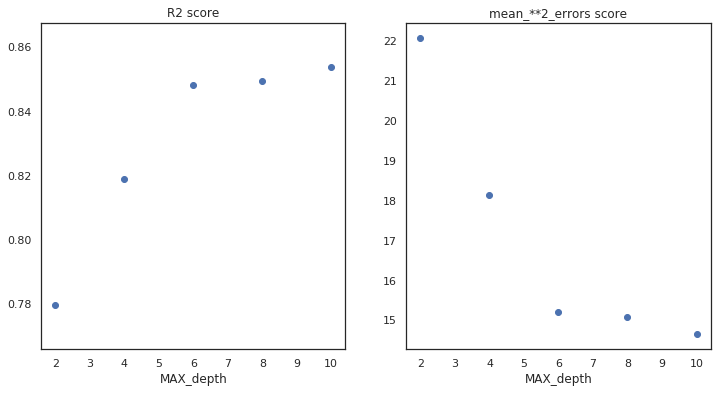

In [25]:
# Produce a plot with the score for the testing and training for the different max depths

y_pred = [m.predict(X_test) for m in models]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(depths, [performance_metric(y_test, p)[0] for p in y_pred])
axs[0].set_title("R2 score")
axs[0].set_xlabel("MAX_depth")

axs[1].scatter(depths, [performance_metric(y_test, p)[1] for p in y_pred])
axs[1].set_title("mean_**2_errors score")
axs[1].set_xlabel("MAX_depth")

plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [40]:
# Your response here

## looks like model performance is increasing up to a max depth of 6. after that it barely improves anything

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [41]:
# Your response here
badbadmodel = RandomForestRegressor(max_depth=1, n_estimators=10, random_state=24).fit(X_train, y_train)
badbadpredict = badbadmodel.predict(X_test)
performance_metric(y_test, badbadpredict)

## it's a bad bad model with too high variance and a miserable capacity to predict, as indicated by the high MSE and low R2 score respective

(0.5799295139090159, 42.09529222259632)

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [34]:
# Five separate RFR here with the given max depths
models = [RandomForestRegressor(max_depth=i, n_estimators=20, random_state=54654).fit(X_train, y_train) for i in range(1, 14)]

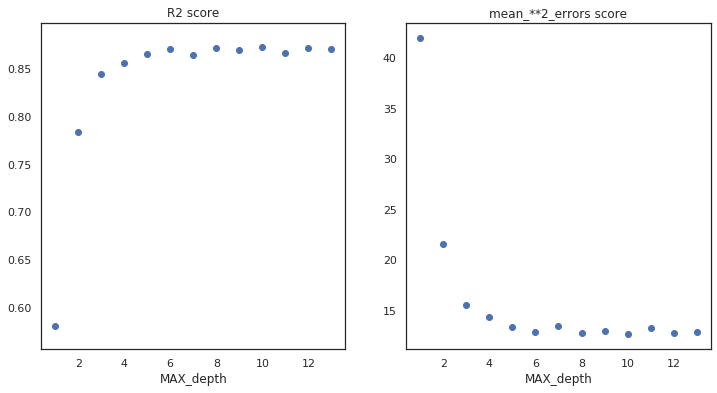

In [37]:
y_pred = [m.predict(X_test) for m in models]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter([i for i in range(1, 14)], [performance_metric(y_test, p)[0] for p in y_pred])
axs[0].set_title("R2 score")
axs[0].set_xlabel("MAX_depth")

axs[1].scatter([i for i in range(1, 14)], [performance_metric(y_test, p)[1] for p in y_pred])
axs[1].set_title("mean_**2_errors score")
axs[1].set_xlabel("MAX_depth")

plt.show()

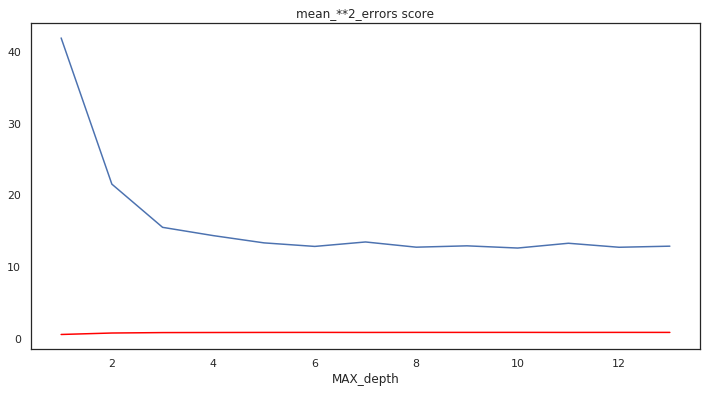

In [39]:
y_pred = [m.predict(X_test) for m in models]
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
axs.plot([i for i in range(1, 14)], [performance_metric(y_test, p)[0] for p in y_pred], color = 'red')
axs.set_title("R2 score")
axs.set_xlabel("MAX_depth")

axs.plot([i for i in range(1, 14)], [performance_metric(y_test, p)[1] for p in y_pred])
axs.set_title("mean_**2_errors score")
axs.set_xlabel("MAX_depth")

plt.show()

In [42]:
## I'm actually not entirely sure if I'm interpreting this correctly, but i feel like the point where max depth starts hitting a plateau is ~4

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [43]:
'''perhapes the model could be useful if we found a way to travel back in time.

there is no way that the determinants of price for a house in 2020 are the same as in 1978

the features present in the data seem to be able to describe a house price quite well ~85% of the variance explained by the model, but I guess being 
wrong by up to 15% is a very big margin of error for a house price. I find it incredible that there is no
square meters in our model O.o probably there's some proxy for it but oh well. idk

the question about the model being robust enough to make predictions actually depends on what you're comparing it to.

it's better than me at predicting house prices for Boston in 1978, so I'd use this model instead of my own hunches,
or as we say it in Portuguese, my 'postas de pescada'. But if you're giving it an adversary such as a 1978 Real 
Estate Agent from Boston, it would probably underperform...

No. Boston Data works for boston, a rural city will absolutely have different determinators of price. If it's in the
US i'm willing to put my money down that the ratio of black people in the neighborhood will be much more negatively
correlated with house price. #MAGAHATS #REDNECKS'''